# Setup

In [1]:
from pathlib import Path
import os

import torch
from torch import nn
from torch.utils.data import TensorDataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from FUCCIDataset import FUCCIDatasetInMemory, ReferenceChannelDatasetInMemory, FUCCIChannelDatasetInMemory
from LightningModules import AutoEncoder, FUCCIDataModule
import lightning.pytorch as pl
from lightning.pytorch.callbacks import BasePredictionWriter

In [2]:
samples_ct = 10
replicates = 30
save_path = Path("/data/ishang/nb_data/")
data_path = Path("/data/ishang/Fucci-dataset-v3_filtered/")
# model_path = Path("/data/ishang/fucci_vae/FUCCI_reference_VAE_2023_06_07_11_56/lightning_logs/23-754918.69.ckpt")
model_path = Path("/data/ishang/fucci_vae/FUCCI_reference_VAE_2023_06_15_08_04/lightning_logs/499-380355.34.ckpt") #regularized
channel = "reference"
# model_path = Path("/data/ishang/fucci_vae/fucci_256_512_2023_05_24_05_47/lightning_logs/epoch=434-Val_loss=0.00.ckpt")
# channel = "fucci"
assert channel in str(model_path)
assert model_path.exists()
if not data_path.exists():
    os.mkdir(data_path)

In [3]:
model = AutoEncoder.load_from_checkpoint(model_path)

In [4]:
mu_file = data_path / (channel + "_mu.pt")
var_file = data_path / (channel + "_logvar.pt")
indices_file = data_path / (channel + "_indices.npy")
colors_file = data_path / "colors.npy"

In [5]:
mu = torch.load(mu_file)
logvar = torch.load(var_file)
print(torch.isnan(mu).sum(), torch.isnan(logvar).sum())
print(torch.isinf(mu).sum(), torch.isinf(logvar).sum())
print(torch.isnan(torch.exp(logvar)).sum(), torch.isinf(torch.exp(logvar)).sum())
var = torch.exp(logvar)
indices = np.load(indices_file)
colors = np.load(colors_file)
latent_dim = mu.shape[1]
print(f"Latent dim: {latent_dim}")

tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
Latent dim: 512


In [6]:
print(mu.min(), mu.mean(), mu.max())
print(mu.min(), mu.median(), mu.max())
print(torch.pow(mu.var(), 0.5))

tensor(-23.5699) tensor(0.0091) tensor(24.2539)


tensor(-23.5699) tensor(0.0129) tensor(24.2539)
tensor(1.7325)


In [7]:
print(torch.sqrt(var).min(), torch.sqrt(var).mean(), torch.sqrt(var).max())
print(torch.sqrt(var).min(), torch.sqrt(var).median(), torch.sqrt(var).max())

tensor(0.1050) tensor(0.6477) tensor(3.2188)


tensor(0.1050) tensor(0.6550) tensor(3.2188)


In [8]:
dataset = ReferenceChannelDatasetInMemory(data_path, imsize=256) if channel == "reference" else FUCCIChannelDatasetInMemory(data_path, imsize=256)

# Exploration

In [9]:
# plot the mean and standard deviation of each channel in the latent space
d = 4
# q = torch.Tensor([1 / d * i for i in range(d + 1)])
q = torch.Tensor([0.2, 0.4, 0.5, 0.6, 0.8])
q = torch.Tensor([0.25, 0.5, 0.75])

mu_q = torch.quantile(mu, q, dim=0)
print(mu_q.shape)
print(mu_q[:10, :10])

# diff = mu_q[0] - mu_q[-1]
# print(diff.shape)
# metric = diff

emp_std = torch.std(mu, dim=0)
print(emp_std.shape)
metric = emp_std

sorted_indices = np.argsort(metric.numpy())
# print(sorted_indices)

std_q = torch.quantile(torch.sqrt(var), q, dim=0)
print(std_q.shape)
print(std_q[:10, :10])


torch.Size([3, 512])
tensor([[-1.2359e-03, -1.0187e+00, -4.3665e-01, -1.7756e-01, -2.5400e+00,
         -1.3507e+00, -2.0323e+00, -1.9944e+00, -1.1807e+00,  5.7138e-02],
        [ 7.7602e-01, -2.0527e-01, -2.0637e-01,  1.0002e-01, -5.5196e-01,
          1.4063e-01,  4.4951e-01, -5.5006e-01, -2.8806e-01,  7.6298e-01],
        [ 1.4028e+00,  7.1308e-01,  6.4150e-02,  3.2896e-01,  1.6964e+00,
          1.5954e+00,  2.8392e+00,  1.0428e+00,  7.3232e-01,  1.3649e+00]])
torch.Size([512])
torch.Size([3, 512])
tensor([[0.5579, 0.4984, 0.7269, 0.7574, 0.2768, 0.3585, 0.2320, 0.3698, 0.4345,
         0.5535],
        [0.6514, 0.5635, 0.8029, 0.8382, 0.3087, 0.3902, 0.2531, 0.4117, 0.5026,
         0.6341],
        [0.7435, 0.6478, 0.8633, 0.9194, 0.3491, 0.4380, 0.2815, 0.4606, 0.5843,
         0.7126]])


<Axes: >

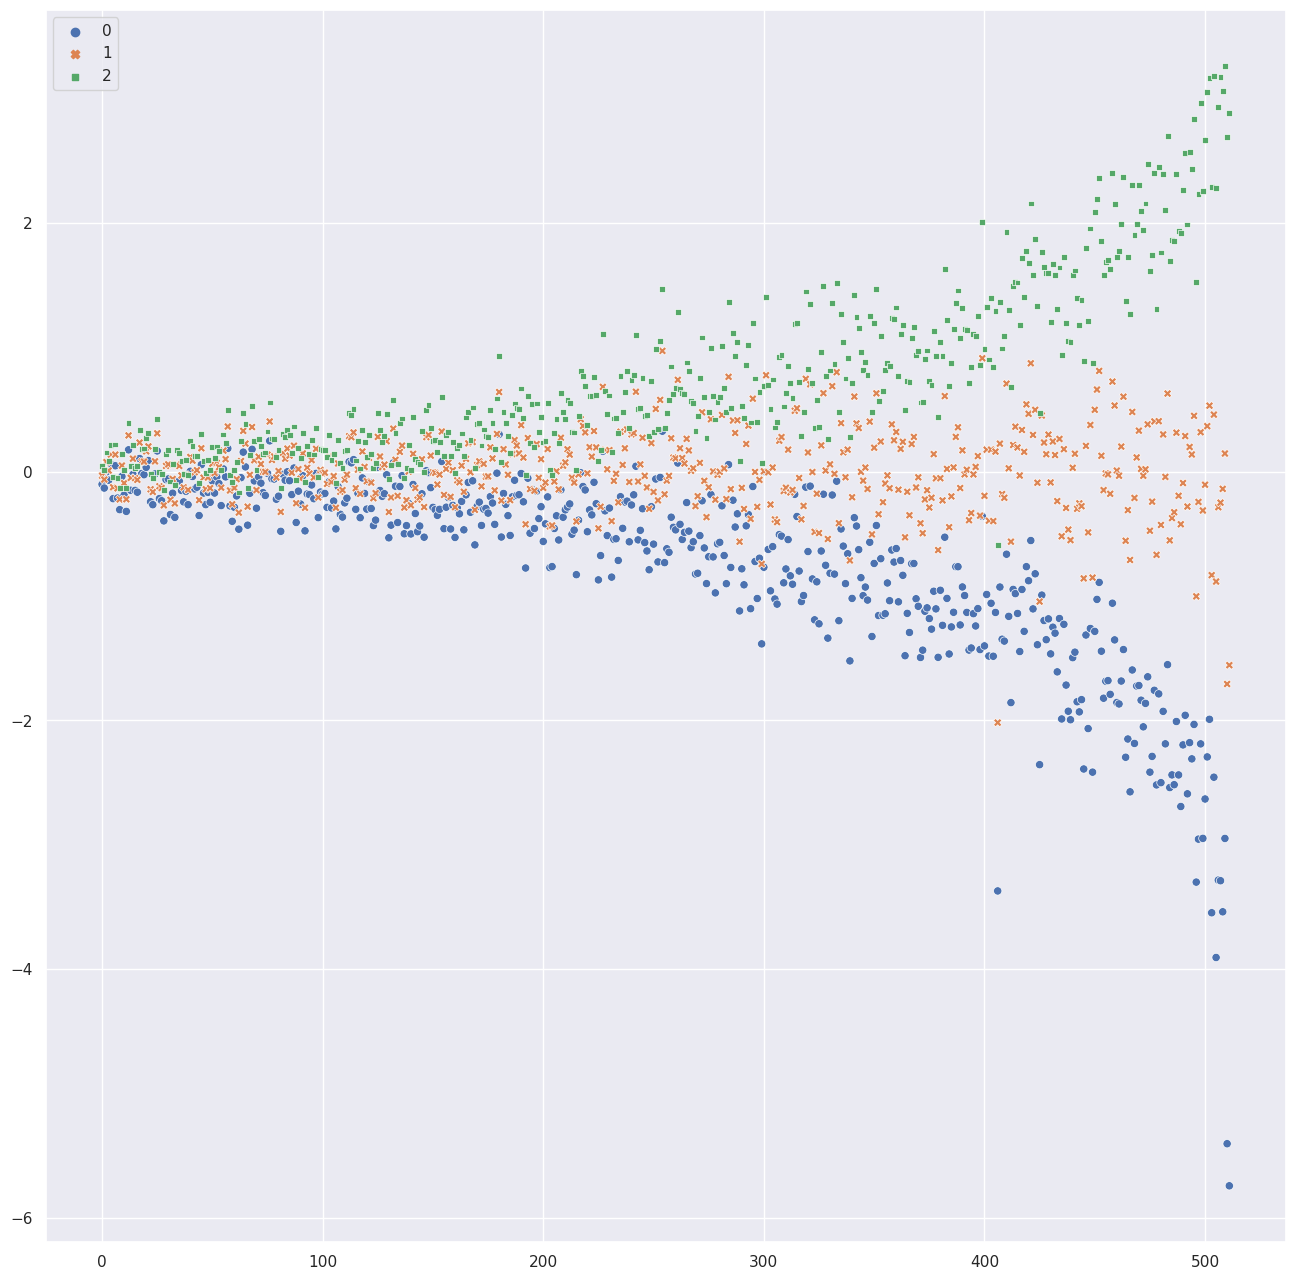

In [10]:
mu_q_sorted = mu_q[:, sorted_indices]
sns.set(rc={'figure.figsize':(16,16)})
sns.scatterplot(data=mu_q_sorted.T.numpy())

<Axes: >

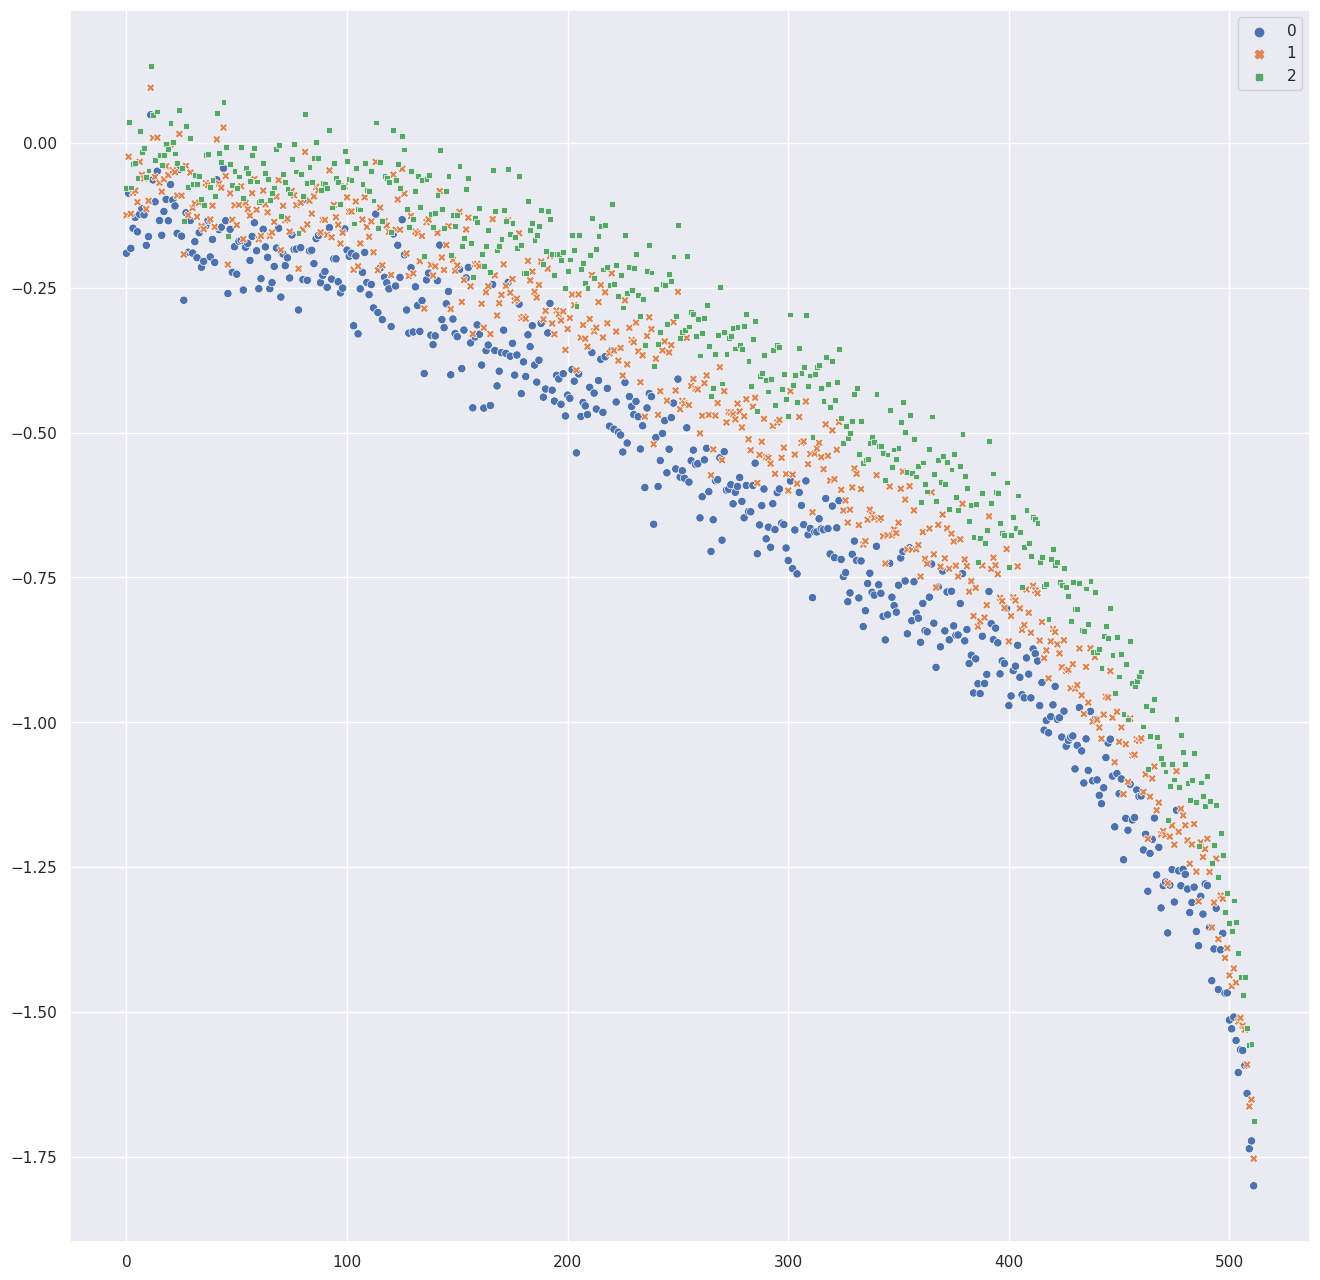

In [11]:
std_q_sorted = std_q[:, sorted_indices]
sns.scatterplot(data=torch.log(std_q_sorted).T.numpy())

torch.Size([512])


Text(0.5, 1.0, 'Distance Between Input Embeddings and Centroid')

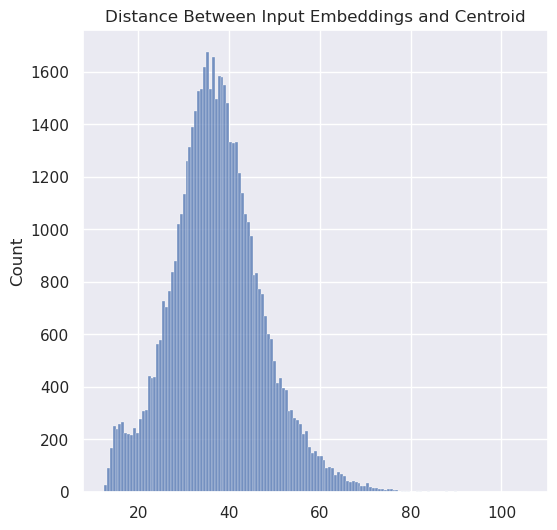

In [12]:
sns.set(rc={'figure.figsize':(6,6)})
centroid = torch.mean(mu, dim=0)
print(centroid.shape)
distances = torch.linalg.vector_norm(mu[:, :] - centroid[None, :], dim=1)
sns.histplot(distances)
plt.title("Distance Between Input Embeddings and Centroid")

Text(0.5, 1.0, 'Quantiles of Distance Between Input Embeddings and Centroid')

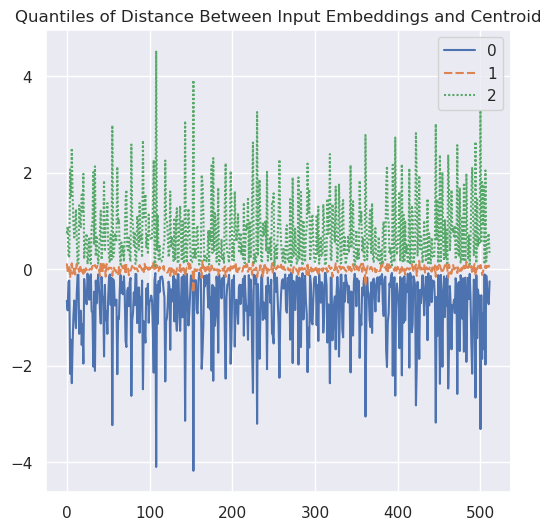

In [17]:
centroid = torch.mean(mu, dim=0)
distances = mu[:, :] - centroid[None, :]
dimension_quantiles = torch.quantile(distances, q, dim=0)
sns.lineplot(data=dimension_quantiles.T.numpy())
plt.title("Quantiles of Distance Between Input Embeddings and Centroid")

tensor(53.8331) tensor(10.7382)


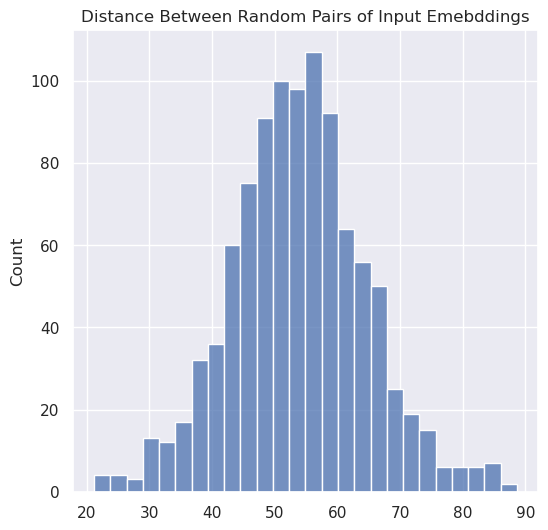

In [18]:
sample_indices = np.random.choice(len(dataset), 1000, replace=False)
sample_mu = mu[sample_indices]
partner_indices = np.random.choice(len(dataset), 1000, replace=False)
partner_mu = mu[partner_indices]
distance = torch.linalg.vector_norm(sample_mu[:, :] - partner_mu[:, :], dim=1)
print(distance.mean(), distance.std())
sns.set(rc={'figure.figsize':(6,6)})
sns.histplot(distance)
plt.title("Distance Between Random Pairs of Input Emebddings")
plt.show()

# Error-Distance Dependency

In [21]:
# target_distances = torch.randn(replicates) * distance.std() + distance.mean()
base = 10
base_scale = 1 / np.log(base)
range_extension = 1
# start = torch.log(distance.min() + 1) * base_scale
start = torch.scalar_tensor(0.0)
end = torch.log(distance.max() * range_extension) * base_scale
print(distance.min(), distance.max())
print(torch.pow(base, start), torch.pow(base, end))
target_distances = torch.logspace(start.item(), end.item(), replicates, base=base)
scale = torch.pow(target_distances, 2) / torch.sum(mu.var(dim=0))
print(target_distances)
print(scale)

tensor(21.2073) tensor(88.6392)
tensor(1.) tensor(88.6392)
tensor([ 1.0000,  1.1672,  1.3624,  1.5903,  1.8563,  2.1667,  2.5290,  2.9520,
         3.4457,  4.0219,  4.6946,  5.4797,  6.3961,  7.4658,  8.7143, 10.1717,
        11.8728, 13.8584, 16.1760, 18.8812, 22.0389, 25.7247, 30.0268, 35.0484,
        40.9099, 47.7516, 55.7375, 65.0589, 75.9392, 88.6392])
tensor([6.6970e-04, 9.1243e-04, 1.2431e-03, 1.6937e-03, 2.3076e-03, 3.1440e-03,
        4.2835e-03, 5.8360e-03, 7.9512e-03, 1.0833e-02, 1.4759e-02, 2.0109e-02,
        2.7397e-02, 3.7327e-02, 5.0857e-02, 6.9289e-02, 9.4403e-02, 1.2862e-01,
        1.7524e-01, 2.3875e-01, 3.2528e-01, 4.4318e-01, 6.0381e-01, 8.2266e-01,
        1.1208e+00, 1.5271e+00, 2.0805e+00, 2.8346e+00, 3.8620e+00, 5.2618e+00])


In [22]:
sample_indices = np.random.choice(len(dataset), samples_ct, replace=False)
sample_mu = mu[sample_indices]
emp_std = torch.sqrt(scale[:, None] * mu.var(dim=0)[None, :])

print(sample_mu.shape)

eps_shape = [samples_ct, replicates, latent_dim] # 5 samples per example data point
# for d in sample_mu.shape:
#     eps_shape.append(d)

eps = torch.randn(eps_shape)
print(eps.shape, emp_std.shape, sample_mu.shape)
samples = eps[:, :, :] * emp_std[None, :, :] + sample_mu[:, None, :]
print(samples.shape, emp_std.shape, sample_mu.shape)
print(samples.min(), samples.mean(), samples.max())

torch.Size([10, 512])
torch.Size([10, 30, 512]) torch.Size([30, 512]) torch.Size([10, 512])
torch.Size([10, 30, 512]) torch.Size([30, 512]) torch.Size([10, 512])
tensor(-46.0173) tensor(0.0159) tensor(28.4996)


torch.Size([10, 30])
tensor([21.2127, 20.6668, 19.7837, 20.7525, 19.7129])
tensor([26.0939, 24.6168, 23.0545, 24.2384, 22.5451])


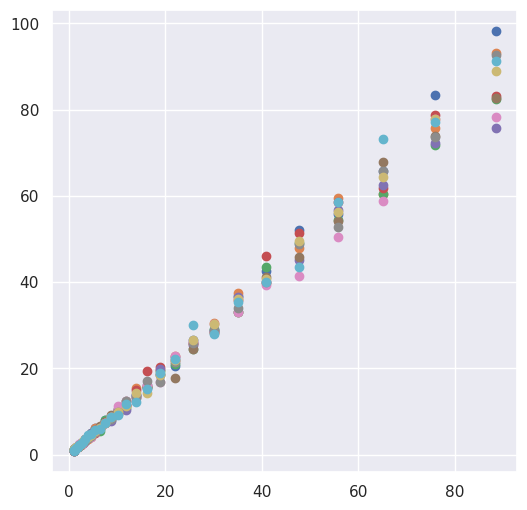

tensor(-44.3663) tensor(0.0034) tensor(22.4845)


In [23]:
sample_dist = (samples[:, :, :] - sample_mu[:, None, :]).squeeze()
sample_diff = torch.linalg.vector_norm(sample_dist, dim=2)
print(sample_diff.shape)
print(torch.mean(sample_diff, dim=1)[:5])
print(torch.std(sample_diff, dim=1)[:5])
for i in range(samples_ct):
    plt.scatter(target_distances, sample_diff[i, :])
plt.show()

print(sample_dist.min(), sample_dist.mean(), sample_dist.max())

In [24]:
samples = samples.reshape(-1, samples.shape[-1])
# samples = torch.stack([samples, samples], dim=1)
# samples[:, 1, :] = 0

In [25]:
class CustomWriter(BasePredictionWriter):

    def __init__(self, output_dir, write_interval):
        super().__init__(write_interval)
        self.output_dir = output_dir

    def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
        # this will create N (num processes) files in `output_dir` each containing
        # the predictions of it's respective rank
        torch.save(predictions, os.path.join(self.output_dir, f"predictions_{trainer.global_rank}.pt"))

        # optionally, you can also save `batch_indices` to get the information about the data index
        # from your prediction data
        torch.save(batch_indices, os.path.join(self.output_dir, f"batch_indices_{trainer.global_rank}.pt"))


In [26]:
from torch.utils.data import Dataset

class SimpleDataset(Dataset):
    def __init__(self, tensor) -> None:
        self.tensor = tensor

    def __getitem__(self, index):
        return self.tensor[index]

    def __len__(self):
        return self.tensor.size(0)

In [27]:
predictions_dir = save_path / "sample_predictions"
if not predictions_dir.exists():
    os.mkdir(predictions_dir)
for f in predictions_dir.glob("*"):
    f.unlink()
pred_writer = CustomWriter(output_dir=predictions_dir, write_interval="epoch")

sample_dm = pl.LightningDataModule.from_datasets(predict_dataset=SimpleDataset(samples), batch_size=replicates, num_workers=1)
print(samples.shape)
print(len(SimpleDataset(samples)))
print(len(sample_dm.predict_dataloader()))

model.set_predict_mode("sampling")

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[pred_writer])
trainer.predict(model, datamodule=sample_dm, return_predictions=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([300, 512])
300
10


You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [28]:
!ls /data/ishang/nb_data/sample_predictions/

batch_indices_0.pt  predictions_0.pt


In [29]:
batch_indices = torch.load(predictions_dir / "batch_indices_0.pt")[0]
predictions = torch.load(predictions_dir / "predictions_0.pt")
print(len(batch_indices), len(predictions))
print(len(batch_indices), predictions[0].shape)
predictions = torch.stack(predictions, dim=0)

10 10
10 torch.Size([30, 2, 256, 256])


In [30]:
indices = [i for batch in batch_indices for i in batch]
for i in range(len(indices)):
    assert indices[i] == i

torch.Size([10, 30, 2, 256, 256]) torch.Size([10, 2, 256, 256])


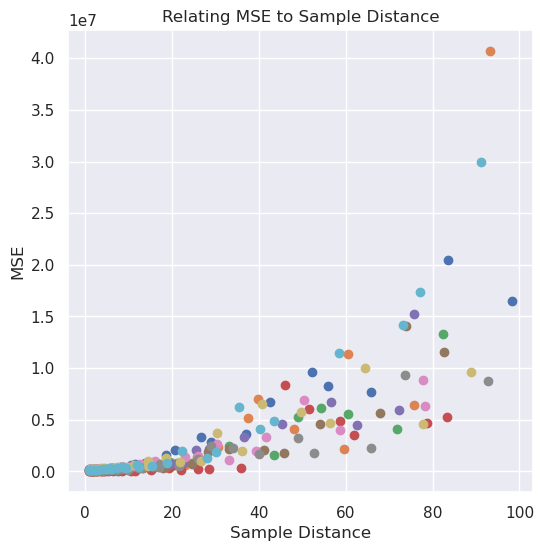

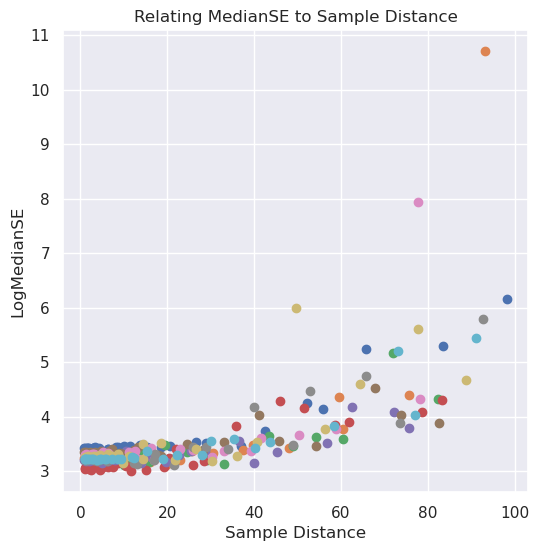

In [31]:
targets = dataset[sample_indices]
print(predictions.shape, targets.shape)
se = torch.pow(predictions[:, :, :, :] - targets[:, None, :, :], 2)
mse = se.mean(dim=(2, 3, 4))
med = se.reshape(samples_ct, replicates, -1).median(dim=(2)).values


for i in range(10):
    plt.scatter(sample_diff[i], mse[i])
plt.xlabel("Sample Distance")
plt.ylabel("MSE")
plt.title(f"Relating MSE to Sample Distance")
plt.show()

plt.clf()
for i in range(10):
    plt.scatter(sample_diff[i], torch.log(med[i]))
plt.xlabel("Sample Distance")
plt.ylabel("LogMedianSE")
plt.title(f"Relating MedianSE to Sample Distance")
plt.show()

In [33]:
boxplot_se = torch.swapaxes(se.reshape(samples_ct, replicates, -1), 0, 1).numpy()
# # q = [0.001, 0.01, 0.05, 0.1, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
# q = [0.2, 0.4, 0.6, 0.8]
n_q = 20
q = [1 / n_q * i for i in range(0, n_q + 1)]
quantiles = np.quantile(np.log(boxplot_se), q=q, axis=(1, 2))
print(sample_diff.shape, mse.shape, med.shape)
print(quantiles.shape)

# x = torch.permute(target_distances.tile((samples_ct, 2 * 256 * 256, 1)), (2, 0, 1))
# sns.boxplot(x=x.reshape(-1).numpy(), y=boxplot_se.reshape(-1))

torch.Size([10, 30]) torch.Size([10, 30]) torch.Size([10, 30])
(21, 30)


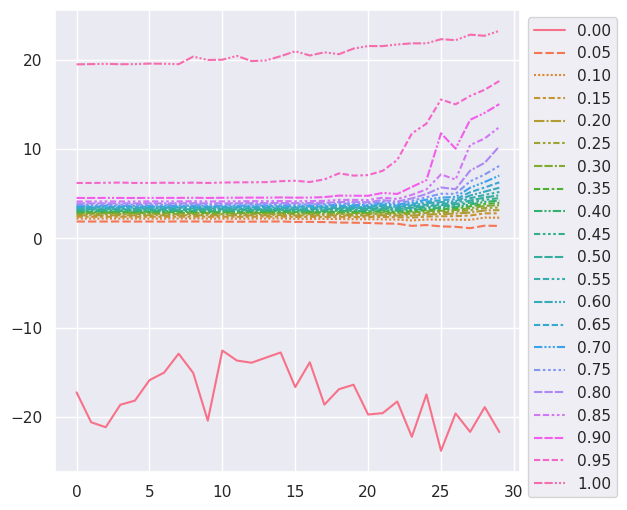

In [34]:
error_quantiles_df = pd.DataFrame(quantiles.T, columns=[f"{q_i:0.2f}" for q_i in q])
ax = sns.lineplot(data=error_quantiles_df)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.yscale("log")

torch.Size([10, 512]) torch.Size([10, 512])
torch.Size([10, 2, 256, 256]) torch.Size([10, 2, 256, 256])
torch.Size([10]) torch.Size([10])


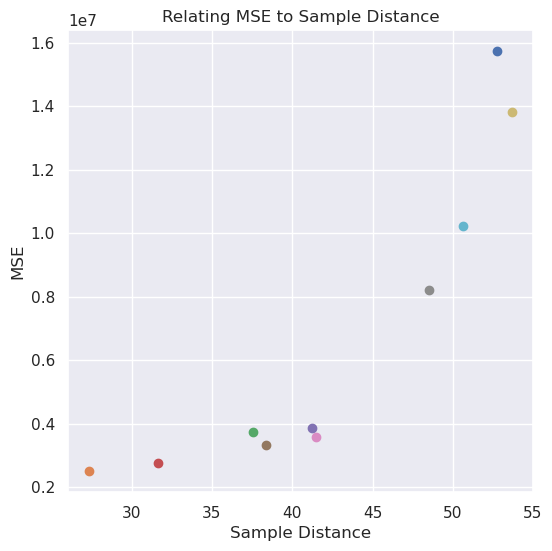

In [35]:
partner_indices = np.random.choice(predictions.shape[0], predictions.shape[0], replace=False)
partner_preds = targets[partner_indices]
partner_mu = sample_mu[partner_indices]
print(sample_mu.shape, partner_mu.shape)
distance = torch.linalg.vector_norm(sample_mu[:, :] - partner_mu[:, :], dim=1)
print(targets.shape, partner_preds.shape)
mse = torch.pow(targets[:, :, :, :] - partner_preds[:, :, :, :], 2).mean(dim=(1, 2, 3))
print(distance.shape, mse.shape)
for i in range(10):
    plt.scatter(distance[i], mse[i])
plt.xlabel("Sample Distance")
plt.ylabel("MSE")
plt.title(f"Relating MSE to Sample Distance")
plt.show()

# Attractor Detection

In [36]:
# quick and dirty check for fixed-point

sample_indices = np.random.choice(len(dataset), 10, replace=False)
samples = dataset[sample_indices]
print(sample_indices)

predictions_dir = save_path / "sample_embeddings"
if not predictions_dir.exists():
    os.mkdir(predictions_dir)
for f in predictions_dir.glob("*"):
    f.unlink()
pred_writer = CustomWriter(output_dir=predictions_dir, write_interval="epoch")

sample_dm = pl.LightningDataModule.from_datasets(predict_dataset=SimpleDataset(samples), batch_size=2, num_workers=1)
print(samples.shape)
print(len(SimpleDataset(samples)))
print(len(sample_dm.predict_dataloader()))

model.set_predict_mode("embedding")

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[pred_writer])
trainer.predict(model, datamodule=sample_dm, return_predictions=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


[19885 35760 49121 50637 17209 28716 46642 16838 29640  1898]
torch.Size([10, 2, 256, 256])
10
5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [37]:
predictions = torch.load(predictions_dir / "predictions_0.pt")
print(len(predictions))
batch_indices = torch.load(predictions_dir / "batch_indices_0.pt")[0]
print(len(batch_indices))
print(predictions[0][0].mean(), predictions[0][1].mean())
print(predictions[0][0].var(), predictions[0][1].var())
print(predictions[0][0].min(), predictions[0][1].min())
print(predictions[0][0].max(), predictions[0][1].max())
predicted_mu = torch.cat([p[0] for p in predictions])
print(predicted_mu.shape)
batch_indices = [i for batch in batch_indices for i in batch]
print(len(batch_indices), len(sample_indices))
print(batch_indices)

5
5
tensor(0.0097) tensor(-1.2204)
tensor(3.4139) tensor(0.6144)
tensor(-9.7099) tensor(-3.6796)
tensor(11.0675) tensor(0.1135)
torch.Size([10, 512])
10 10
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [38]:
mu_sample = mu[[sample_indices[i] for i in batch_indices]]
assert torch.all(dataset[[sample_indices[i] for i in batch_indices]] == samples)
print(mu_sample.shape, predicted_mu.shape)
distance = torch.linalg.vector_norm(mu_sample[:, :] - predicted_mu[:, :], dim=1)
print(distance.shape)
print(distance.min(), distance.mean(), distance.max())
print(distance)


torch.Size([10, 512]) torch.Size([10, 512])
torch.Size([10])
tensor(0.0112) tensor(0.0148) tensor(0.0170)
tensor([0.0121, 0.0138, 0.0164, 0.0148, 0.0162, 0.0168, 0.0170, 0.0153, 0.0112,
        0.0144])


In [52]:
# sample images then calculate the jacobian of the combined encoder and decoder
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_samples = 10
sample_indices = np.random.choice(len(dataset), num_samples, replace=False)
predictions_dir = save_path / "sample_predictions"
samples = torch.Tensor(dataset[sample_indices]).to(device)

E = model.encoder
D = model.decoder

class SimpleAE(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        mu, var = self.encoder(x)
        x_hat = self.decoder(mu)
        return x_hat

simple_model = SimpleAE(E, D).cuda()

samples.requires_grad = True
reconstruction = simple_model(samples).reshape(num_samples, -1)
samples = samples.reshape(num_samples, -1)
jacob = torch.autograd.grad(reconstruction, samples, grad_outputs=torch.ones_like(reconstruction))[0]
print(type(jacob), type(samples), type(reconstruction))
print(jacob.shape, samples.shape, reconstruction.shape)
(eigenvalues, eigenvectors) = torch.linalg.eig(jacob)

# from torch.autograd.functional import jacobian
# j = jacobian(simple_model, samples[None, 0])
# print(j.shape)


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.